In [1]:
import librosa
import librosa.effects
import colorednoise as cn
from pydub import AudioSegment, effects

import numpy as np
import os
import pandas as pd
import soundfile as sf
import torch
import fastai.torch_core
from fastai.vision.all import *
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import zipfile
import IPython.display as ipd
import random
import shutil
import imageio
import matplotlib.cm as cm

C:\Users\Lars Magnus Nordeide\PycharmProjects\dat255-audio_project-g11\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# setup

In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.

DATA_DIR = Path(os.getcwd())
try:
    import google.colab
    colab=True
    
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA_DIR = Path('/content/gdrive/MyDrive/DAT255')
except:
    DATA_DIR = DATA_DIR / '..' / 'data'
    colab=False
    
DATA_DIR.mkdir(parents=True, exist_ok=True)

SUB_DIRS = ['external','interim','processed','raw']    

for d in SUB_DIRS:
    dir_path = DATA_DIR / d
    dir_path.mkdir(parents=True, exist_ok=True)
    
DATA_DIR
    

Path('C:/Users/Lars Magnus Nordeide/PycharmProjects/dat255-audio_project-g11/notebooks/../data')

In [3]:
if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [4]:
device = None
if torch.cuda.is_available():
    device = fastai.torch_core.default_device('cuda')
elif torch.backends.mps.is_available():
    device = fastai.torch_core.default_device('mps')
else:
    device = fastai.torch_core.default_device('cpu')
    
device

device(type='cpu')

# Download data

In [8]:
def download_and_unzip(url, dir_name):
    if not os.path.isdir(dir_name):
        # Download the file
        response = requests.get(url)
        zip_file_name = f"{dir_name}.zip"
        with open(zip_file_name, 'wb') as f:
            f.write(response.content)

        # Unzip the file
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall(dir_name)

        # Remove the zip file
        os.remove(zip_file_name)

DOWNLOAD_PATH = DATA_DIR / 'external' / 'fsdkaggle2018'
DOWNLOAD_PATH.mkdir(parents=True, exist_ok=True)

download_and_unzip('https://zenodo.org/records/2552860/files/FSDKaggle2018.audio_test.zip', DOWNLOAD_PATH)
download_and_unzip('https://zenodo.org/records/2552860/files/FSDKaggle2018.audio_train.zip', DOWNLOAD_PATH)
download_and_unzip('https://zenodo.org/records/2552860/files/FSDKaggle2018.meta.zip', DOWNLOAD_PATH)

# List the current directory contents
print(os.listdir(DOWNLOAD_PATH))

['FSDKaggle2018.meta', 'FSDKaggle2018.audio_train', 'FSDKaggle2018.audio_test']



['FSDKaggle2018.audio_test', 'FSDKaggle2018.audio_train', 'FSDKaggle2018.meta']


['FSDKaggle2018.meta', 'FSDKaggle2018.audio_train', 'FSDKaggle2018.audio_test']

In [9]:
meta = pd.read_csv(DOWNLOAD_PATH / 'FSDKaggle2018.meta' / 'train_post_competition.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Lars Magnus Nordeide\\PycharmProjects\\dat255-audio_project-g11\\notebooks\\..\\data\\external\\fsdkaggle2018\\FSDKaggle2018.meta\\train_post_competition.csv'

In [9]:
# Add a column for the path to the audio file
meta['path'] = meta['fname'].apply(lambda x: os.path.join(DOWNLOAD_PATH, 'FSDKaggle2018.audio_train', x))

In [10]:
meta.head()

,fname,label,manually_verified,freesound_id,license,path
0,00044347.wav,Hi-hat,0,28739,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav
1,001ca53d.wav,Saxophone,1,358827,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav
3,0033e230.wav,Glockenspiel,1,325017,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav
4,00353774.wav,Cello,1,195688,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav


- Lets sort out non-musical labels

In [11]:
# first print all the labels in the dataset
labels = meta['label'].unique()
print(labels)

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


In [12]:
# musical labels
musical_labels = ['Hi-hat', 'Saxophone','Trumpet', 'Glockenspiel', 'Cello','Clarinet','Snare_drum','Oboe', 'Flute','Chime', 'Bass_drum','Harmonica', 'Gong','Double_bass','Tambourine', 'Cowbell', 'Electric_piano','Acoustic_guitar', 'Violin_or_fiddle',
 'Finger_snapping' ]

In [13]:
# Then we can filter the dataset to only include the musical labels
musical_meta = meta[meta['label'].isin(musical_labels)]

# mixing audio clips

- Experimenting with mixing audio clips

In [14]:
def mix_audio_clips(clip_paths, output_path, sr=44100):
    # Load the first clip
    mixed_clip, _ = librosa.load(clip_paths[0], sr=sr)
    
    # Load and mix each subsequent clip
    for clip_path in clip_paths[1:]:
        clip, _ = librosa.load(clip_path, sr=sr)
        # Ensure the clips are of the same length
        min_len = min(len(mixed_clip), len(clip))
        mixed_clip = mixed_clip[:min_len] + clip[:min_len]
        
    # Normalize the mixed clip to prevent clipping
    mixed_clip = mixed_clip / np.max(np.abs(mixed_clip))
    
    # Save the mixed clip to an output file
    sf.write(output_path, mixed_clip, sr)

In [15]:
# Example usage
path1 = DOWNLOAD_PATH / "FSDKaggle2018.audio_train" / "0a0a8d4c.wav"
path2 = DOWNLOAD_PATH / "FSDKaggle2018.audio_train" / "0a2a5c05.wav"

processed_path = DATA_DIR / 'processed'

# Create mixed clips directory if it doesn't exist
mixed_clips_path = os.path.join(processed_path, 'mixed_clips')
if not os.path.exists(mixed_clips_path):
    os.makedirs(mixed_clips_path)

mix_audio_clips([path1, path2], os.path.join(mixed_clips_path, 'mixed_clip.wav'))

In [16]:
# Load the mixed clip and the original clips to compare
ipd.Audio(path1)


In [17]:
ipd.Audio(path2)

In [18]:
ipd.Audio(os.path.join(mixed_clips_path, 'mixed_clip.wav'))

Works fine :)

# Frequency determination

- Want to categorize the clips into frequencies.
- Avoid muddy mixes with clips in same frequency range.
- Mimick realistic audio mixing?

In [19]:
def determine_frequency_range(audio_path, sr=44100):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Compute the short-time Fourier transform (STFT)
    D = np.abs(librosa.stft(y))
    
    # Define the frequency ranges
    ranges = {
        'sub_bass': (20, 60),
        'bass': (60, 250),
        'low_midrange': (250, 500),
        'midrange': (500, 2000),
        'upper_midrange': (2000, 4000),
        'presence': (4000, 6000),
        'brilliance': (6000, 20000),
    }
    
    # Compute the spectral energy in each range
    energy = {name: D[int(low / sr * D.shape[0]):int(high / sr * D.shape[0])].sum()
              for name, (low, high) in ranges.items()}
    
    # Determine the dominant frequency range
    return max(energy, key=energy.get)

In [20]:
# Example usage

# Two random audio clips
path1 = musical_meta.sample(1).iloc[0]['path']
path2 = musical_meta.sample(1).iloc[0]['path']

# Create a DataFrame with the paths of the two audio clips
df = pd.DataFrame({'path': [path1, path2]})

# Determine the frequency range for each clip and add it to the DataFrame
df['frequency_range'] = df['path'].apply(determine_frequency_range)

print(path1, "frequency range: " ,determine_frequency_range(path1), "instrument: ", musical_meta[musical_meta['path'] == path1]['label'].values[0])
print(path2, "frequency range: " , determine_frequency_range(path2), "instrument: ", musical_meta[musical_meta['path'] == path2]['label'].values[0])

/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/238b16a5.wav frequency range:  low_midrange instrument:  Cello
/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9eb77880.wav frequency range:  midrange instrument:  Tambourine


In [21]:
ipd.Audio(path1)

In [23]:
ipd.Audio(path2)

- Usually works

- Now, let's add a range to all the entries.

In [24]:
# Determine the frequency range for all clips in the dataset
musical_meta['frequency_range'] = musical_meta['path'].apply(determine_frequency_range)

/tmp/ipykernel_1153/3206384689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musical_meta['frequency_range'] = musical_meta['path'].apply(determine_frequency_range)


In [25]:
musical_meta.head()

,fname,label,manually_verified,freesound_id,license,path,frequency_range
0,00044347.wav,Hi-hat,0,28739,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav,brilliance
1,001ca53d.wav,Saxophone,1,358827,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav,midrange
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav,midrange
3,0033e230.wav,Glockenspiel,1,325017,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav,upper_midrange
4,00353774.wav,Cello,1,195688,Attribution,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav,midrange


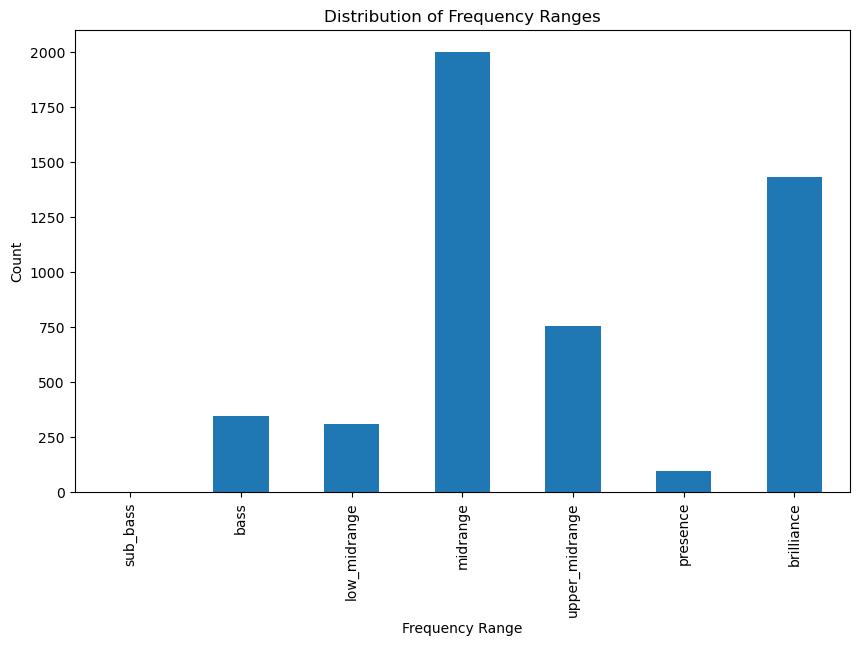

In [27]:
# Define the order of the frequency ranges from low to high
order = ['sub_bass', 'bass', 'low_midrange', 'midrange', 'upper_midrange', 'presence', 'brilliance']

# Plot the distribution of frequency ranges
plt.figure(figsize=(10, 6))
musical_meta['frequency_range'].value_counts().loc[order].plot(kind='bar')
plt.title('Distribution of Frequency Ranges')
plt.xlabel('Frequency Range')
plt.ylabel('Count')
plt.show()


# Mixing clips from different ranges

In [104]:



# Experimental genre-specific adjustments. Might not work as intended. The idea is to apply different effects to the audio clips based on the genre.
genre_instruments = {
    'jazz': ['Saxophone', 'Trumpet', 'Double_bass', 'Snare_drum', 'Hi-hat', 'Clarinet', 'Trombone', 'Electric_piano'],
    'classical': ['Violin_or_fiddle', 'Cello', 'Flute', 'Oboe', 'Clarinet', 'Glockenspiel', 'Chime'],
    'rock': ['Electric_piano', 'Acoustic_guitar', 'Snare_drum', 'Bass_drum', 'Hi-hat', 'Tambourine', 'Cowbell'],
    'blues': ['Saxophone', 'Trumpet', 'Harmonica', 'Electric_piano', 'Acoustic_guitar', 'Snare_drum', 'Hi-hat'],
    'folk': ['Acoustic_guitar', 'Violin_or_fiddle', 'Harmonica', 'Double_bass', 'Flute', 'Tambourine', 'Glockenspiel'],
    'electronic': ['Snare_drum', 'Bass_drum', 'Hi-hat', 'Electric_piano', 'Gong', 'Tambourine', 'Finger_snapping', 'Chime'],
    'world': ['Harmonica', 'Gong', 'Tambourine', 'Cowbell', 'Oboe', 'Chime', 'Flute', 'Double_bass'],
    'wildcard': ['Hi-hat', 'Saxophone', 'Trumpet', 'Glockenspiel', 'Cello', 'Clarinet', 'Snare_drum', 'Oboe', 'Flute', 'Chime', 'Bass_drum', 'Harmonica', 'Gong', 'Double_bass', 'Tambourine', 'Cowbell', 'Electric_piano', 'Acoustic_guitar', 'Violin_or_fiddle', 'Finger_snapping']
}

def adjust_for_genre(clip, genre, sr=44100):
    if genre == 'classical':
        # Increase dynamic range; classical music often has wide dynamic swings
        clip = clip * (1 + np.var(clip))
    elif genre == 'rock':
        # Apply compression to decrease dynamic range; rock music often has a compressed, upfront sound
        clip = librosa.effects.preemphasis(clip)
    elif genre == 'jazz':
        # Slightly increase dynamic range and add a subtle reverb to emulate live jazz environments
        clip = clip * (1 + 0.5 * np.var(clip))
        clip = librosa.effects.preemphasis(clip, coef=0.97)  # Slight pre-emphasis
    elif genre == 'blues':
        # Apply mild compression and a warmer tone by reducing high frequencies
        clip = librosa.effects.preemphasis(clip, coef=0.95)
    elif genre == 'folk':
        # Enhance the natural dynamics and apply a gentle high-pass filter to emulate acoustic settings
        clip = librosa.effects.hpss(clip)[1]
    elif genre == 'electronic':
        # Normalize to ensure uniform loudness levels typical of electronic music
        clip = librosa.util.normalize(clip)
    elif genre == 'world':
        # Apply a slight increase in dynamic range and a moderate reverb to reflect diverse instrumentation and spaces
        clip = clip * (1 + 0.3 * np.var(clip))
    elif genre == 'wildcard':
        # For wildcard, randomly choose to apply one of the effects mildly to not bias the genre
        effects = [lambda x: x, lambda x: librosa.effects.preemphasis(x, coef=0.98), lambda x: x * (1 + 0.2 * np.var(x)), librosa.util.normalize]
        clip = random.choice(effects)(clip)

    return clip


def add_noise(clip, noise_type='white', snr=20):
    if noise_type == 'white':
        # Generate white noise
        noise = np.random.normal(0, 1, len(clip))
    elif noise_type == 'pink':
        # Generate pink noise using colorednoise
        # The exponent for pink noise is 1, beta = 1
        noise = cn.powerlaw_psd_gaussian(1, len(clip))
    elif noise_type == 'brownian':
        # Generate brownian noise using colorednoise
        # The exponent for brownian noise is 2, beta = 2
        noise = cn.powerlaw_psd_gaussian(2, len(clip))
    else:
        # TODO: Load custom noise file. For now do nothing
        return clip
    
    # Calculate signal and noise power, then scale noise to achieve the desired SNR
    sig_power = np.sum(clip ** 2) / len(clip)
    noise_power = np.sum(noise ** 2) / len(noise)
    scale = (sig_power / noise_power) / (10 ** (snr / 10))
    noise = noise * np.sqrt(scale)
    
    return clip + noise

def random_slice_reassemble(audio_segment, num_slices=4):
    slice_length = len(audio_segment) // num_slices
    slices = [audio_segment[i * slice_length:(i + 1) * slice_length] for i in range(num_slices)]
    random.shuffle(slices)
    return sum(slices)

def vary_speed(clip, sr, min_speed=0.9, max_speed=1.1):
    speed_factor = random.uniform(min_speed, max_speed)
    return librosa.effects.time_stretch(clip, rate=speed_factor)

def mix_clips_from_different_ranges(df, genre_instruments, output_file_name, sr=44100, clip_length=3, min_groups=3, max_groups=8):
    # Randomly select a genre
    genre = random.choice(list(genre_instruments.keys()))
    instruments = genre_instruments[genre]

    # Filter df for the selected instruments
    df_genre = df[df['label'].isin(instruments)]

    grouped = df_genre.groupby('frequency_range')  # Group the clips by frequency range
    num_groups = random.randint(min_groups, max_groups)
    selected_groups = random.sample(list(grouped.groups), min(num_groups, len(grouped.groups)))

    selected_clips = [grouped.get_group(group).sample(1).iloc[0] for group in selected_groups]
    mixed_clip = np.zeros(int(sr * clip_length))

    for row in selected_clips:
        clip, _ = librosa.load(row['path'], sr=sr, duration=clip_length)
        
        clip = adjust_for_genre(clip, genre)  # Add genre-specific adjustments
        
        # Randomly vary the speed of the clip
        if random.random() < 0.5:
            clip = vary_speed(clip, sr=sr)
        
        #Randomly slice and reassemble the clip
        if random.random() < 0.5:
            clip = random_slice_reassemble(clip)
        
        # Randomly add noise
        if random.random() < 0.5:  # 50% chance to add noise, adjust this value as needed
            noise_types = ['white', 'pink', 'custom', 'brownian']  # Assuming 'custom' is an option for your own noise file
            noise_type = random.choice(noise_types)  # Randomly select the type of noise to add
            clip = add_noise(clip, noise_type=noise_type)
        
        if len(clip) < len(mixed_clip):
            clip = np.tile(clip, int(np.ceil(len(mixed_clip) / len(clip))))[:len(mixed_clip)]
        mixed_clip += clip[:len(mixed_clip)]
        
    mixed_clip = mixed_clip / np.max(np.abs(mixed_clip))
    output_path = f"{output_file_name}.wav"
    sf.write(output_path, mixed_clip, sr)

    return [row['label'] for row in selected_clips], genre, output_path



In [93]:
# Example mixed clip
output_path = os.path.join(mixed_clips_path, 'mixed_clip_from_different_ranges')
mix_clips_from_different_ranges(musical_meta, genre_instruments, output_path, sr=44100)

(['Hi-hat', 'Bass_drum', 'Flute', 'Bass_drum', 'Flute', 'Electric_piano'],
 'wildcard',
 '/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_from_different_ranges.wav')

In [105]:
def clear_directory(folder_path):
    # Check if the directory exists
    if not os.path.exists(folder_path):
        print(f"The directory {folder_path} does not exist.")
        return
    
    # Loop through all items in the directory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # If it's a file or symlink, delete it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            # If it's a directory, delete it and all its contents
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

def generate_mixed_clips(df, genre_instruments, output_folder, n_clips, sr=44100, clip_length=3):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    elif os.listdir(output_folder):
        clear_directory(output_folder)

    mixed_clips_info = []

    for i in range(n_clips):
        labels, genre, output_path = mix_clips_from_different_ranges(df, genre_instruments, f"{output_folder}/mixed_clip_{i}", sr, clip_length)
        if labels and output_path:
            mixed_clips_info.append({'path': output_path, 'labels': ', '.join(labels), 'genre': genre})

    return pd.DataFrame(mixed_clips_info)


In [96]:
# Example usage
output_folder = mixed_clips_path
n_clips = 5  # Number of mixed clips to generate
mixed_clips_df = generate_mixed_clips(musical_meta, genre_instruments, output_folder, n_clips)

print(mixed_clips_df)

                                                                                                path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav   

                                                                                              labels  \
0  Cowbell, Acoustic_guitar, Acoustic_guitar, Electric_piano, Tambourine, Bass_drum, Acoustic_guitar   
1                             Electric_piano, Clarinet, Double_bass, Double_bass, Snare_drum, Hi-hat   
2                                                   Gong, Elect

# Generating spectrograms

In [103]:
def generate_spectrograms(df, output_dir, fixed_length_seconds=3):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    clear_directory(output_dir)
    
    # Sample rate
    sr = 44100  
    # Calculate fixed length in samples
    fixed_length_samples = int(fixed_length_seconds * sr)
    
    # Initialize an empty list to store spectrogram paths
    spectrogram_paths = []
    
    for index, row in df.iterrows():
        # Load the audio file
        y, sr = librosa.load(row['path'], sr=sr, mono=True)
        
        if len(y) < fixed_length_samples:
            # Calculate the amount of silence needed
            padding_needed = fixed_length_samples - len(y)
            # Generate a random offset for the silence padding
            offset = np.random.randint(0, padding_needed)
            
            # Pad the audio signal with silence before and after based on the random offset
            silence_before = np.zeros(offset)
            silence_after = np.zeros(padding_needed - offset)
            y_padded = np.concatenate((silence_before, y, silence_after))
        else:
            # If the audio is longer than the fixed length, truncate it
            y_padded = y[:fixed_length_samples]
        
        # Generate the spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y_padded, sr=sr, n_mels=128, fmax=22000)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize the spectrogram
        norm_log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
        
        # Apply a colormap
        colored_spec = cm.viridis(norm_log_mel_spec)
        
        # Convert to RGB
        colored_spec_rgb = (colored_spec[..., :3] * 255).astype(np.uint8)

        # Define the file name and save path
        file_name = os.path.basename(row['path']).replace('.wav', '_spectrogram.png')
        save_path = os.path.join(output_dir, file_name)
        
        # Save the spectrogram image
        imageio.imwrite(save_path, colored_spec_rgb)
        
        # Append the save path to the list
        spectrogram_paths.append(save_path)
    
    # Add the list as a new column to the DataFrame
    df['spectrogram_path'] = spectrogram_paths

    return df  # Return the updated DataFrame

In [101]:
mixed_clips_df.head(10)

,path,labels,genre
0,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav,"Cowbell, Acoustic_guitar, Acoustic_guitar, Electric_piano, Tambourine, Bass_drum, Acoustic_guitar",rock
1,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav,"Electric_piano, Clarinet, Double_bass, Double_bass, Snare_drum, Hi-hat",jazz
2,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav,"Gong, Electric_piano, Electric_piano, Tambourine",electronic
3,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav,"Flute, Finger_snapping, Cowbell",wildcard
4,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav,"Chime, Tambourine, Harmonica, Harmonica, Gong",world


In [106]:
generate_spectrograms(mixed_clips_df, os.path.join(processed_path, 'spectrograms'))

,path,labels,genre,spectrogram_path
0,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav,"Cowbell, Acoustic_guitar, Acoustic_guitar, Electric_piano, Tambourine, Bass_drum, Acoustic_guitar",rock,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_0_spectrogram.png
1,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav,"Electric_piano, Clarinet, Double_bass, Double_bass, Snare_drum, Hi-hat",jazz,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_1_spectrogram.png
2,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav,"Gong, Electric_piano, Electric_piano, Tambourine",electronic,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_2_spectrogram.png
3,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav,"Flute, Finger_snapping, Cowbell",wildcard,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_3_spectrogram.png
4,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav,"Chime, Tambourine, Harmonica, Harmonica, Gong",world,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_4_spectrogram.png


# Training a model

In [107]:
# First, let's generate a bunch of mixed clips and spectrograms
n_clips = 1000
output_folder = os.path.join(processed_path, 'mixed_clips')
mixed_clips_df = generate_mixed_clips(musical_meta, genre_instruments, output_folder, n_clips)

output_folder = os.path.join(processed_path, 'spectrograms')
mixed_clips_df = generate_spectrograms(mixed_clips_df, output_folder)

In [108]:
mixed_clips_df.head()

,path,labels,genre,spectrogram_path
0,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav,"Electric_piano, Bass_drum, Acoustic_guitar, Cowbell",rock,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_0_spectrogram.png
1,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav,"Gong, Clarinet, Finger_snapping, Gong, Bass_drum",wildcard,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_1_spectrogram.png
2,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav,"Cowbell, Snare_drum, Electric_piano, Acoustic_guitar, Electric_piano, Cowbell, Acoustic_guitar",rock,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_2_spectrogram.png
3,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav,"Double_bass, Gong, Tambourine, Gong",world,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_3_spectrogram.png
4,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav,"Flute, Cello, Oboe, Cello",classical,/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_4_spectrogram.png


In [137]:
def get_y(r): 
    return r['labels'].split(', ')

def get_x(r): 
    return r['spectrogram_path']

# Create a DataBlock
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               splitter=RandomSplitter(seed=42),
               get_x=get_x,
               get_y=get_y,
               item_tfms=Resize(224)
               )

dls = db.dataloaders(mixed_clips_df, bs=64)

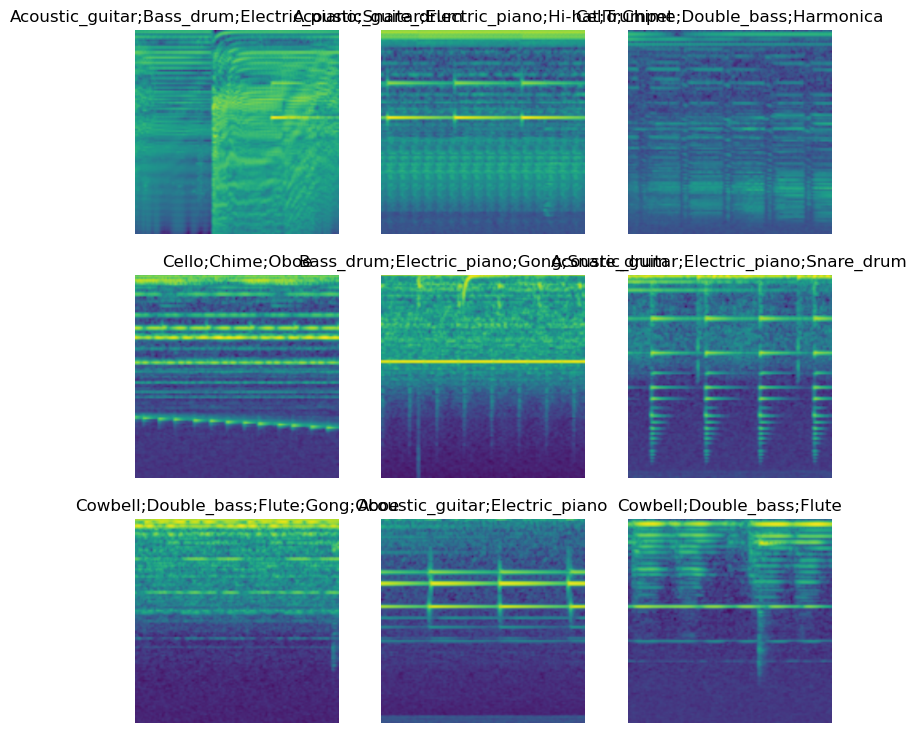

In [138]:
dls.show_batch(max_n=9)

In [139]:
from torch.nn import BCEWithLogitsLoss

learn = vision_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.5), loss_func=BCEWithLogitsLoss())

SuggestedLRs(valley=0.0012022644514217973)


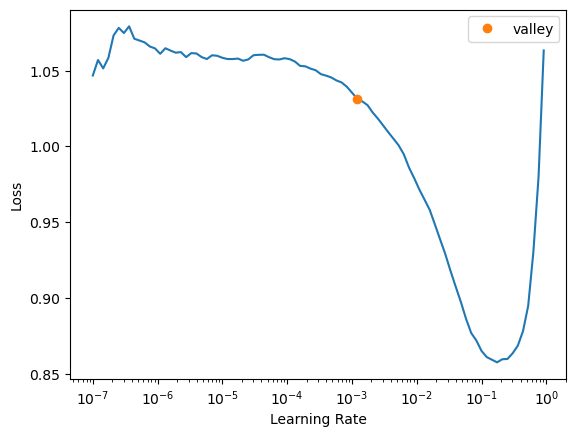

In [140]:
lr = learn.lr_find()
print(lr)

In [141]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.034289,0.781610,0.540750,00:03
1,0.963256,0.692595,0.617250,00:03
2,0.898749,0.665088,0.644000,00:03
3,0.850034,0.645789,0.657000,00:02
4,0.817221,0.638358,0.658250,00:02


In [142]:
print(learn.recorder.values)

[[1.0342886447906494, 0.7816100120544434, 0.5407500267028809], [0.9632558226585388, 0.6925951242446899, 0.6172500252723694], [0.8987492322921753, 0.665088415145874, 0.6439999938011169], [0.8500342965126038, 0.6457893252372742, 0.656999945640564], [0.8172206282615662, 0.6383575797080994, 0.6582500338554382]]


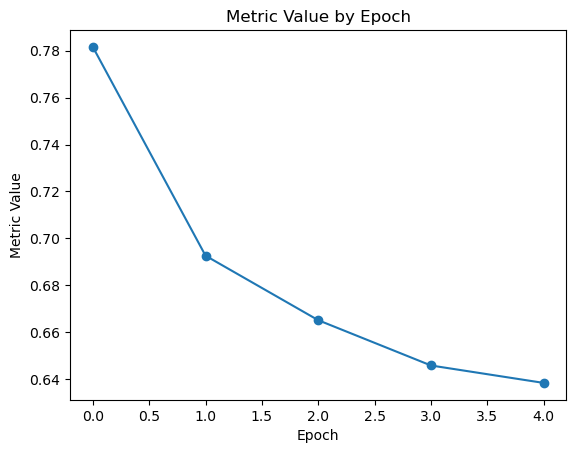

In [144]:
import matplotlib.pyplot as plt

# Assuming `learn` is your Learner object
# and you have a single metric
metric_values = [x[1] for x in learn.recorder.values]

plt.plot(metric_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Metric Value by Epoch')
plt.show()

In [145]:
# Get the predictions and targets
preds, targets = learn.get_preds()

# Convert the predictions to binary using a threshold
threshold = 0.5
binary_preds = (preds > threshold).int()

# Print the first few predictions and targets
for i in range(5):
    print(f"Predictions: {binary_preds[i]}, Targets: {targets[i]}")

Predictions: tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       dtype=torch.int32), Targets: tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])
Predictions: tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       dtype=torch.int32), Targets: tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Predictions: tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       dtype=torch.int32), Targets: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0.])
Predictions: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       dtype=torch.int32), Targets: tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.])
Predictions: tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0],
       dtype=torch.int32), Targets: tensor([0., 0., 0., 0.

In [147]:
class_names = dls.vocab
print(class_names)

['Acoustic_guitar', 'Bass_drum', 'Cello', 'Chime', 'Clarinet', 'Cowbell', 'Double_bass', 'Electric_piano', 'Finger_snapping', 'Flute', 'Glockenspiel', 'Gong', 'Harmonica', 'Hi-hat', 'Oboe', 'Saxophone', 'Snare_drum', 'Tambourine', 'Trumpet', 'Violin_or_fiddle']


In [148]:
# Get the predictions and targets
preds, targets = learn.get_preds()

# Convert the predictions to binary using a threshold
threshold = 0.5
binary_preds = (preds > threshold).int()

# Convert tensors to numpy arrays
binary_preds_np = binary_preds.numpy()
targets_np = targets.numpy()

# Print the first 5 predictions and targets
for i in range(5):
    predicted_labels = [class_names[j] for j in range(len(class_names)) if binary_preds_np[i][j]==1]
    actual_labels = [class_names[j] for j in range(len(class_names)) if targets_np[i][j]==1]
    print(f"Predicted labels: {predicted_labels}, Actual labels: {actual_labels}")

Predicted labels: ['Acoustic_guitar', 'Bass_drum', 'Double_bass', 'Electric_piano', 'Flute', 'Glockenspiel', 'Hi-hat', 'Snare_drum', 'Trumpet'], Actual labels: ['Acoustic_guitar', 'Double_bass', 'Violin_or_fiddle']
Predicted labels: ['Acoustic_guitar', 'Chime', 'Double_bass', 'Flute', 'Glockenspiel', 'Harmonica', 'Tambourine', 'Violin_or_fiddle'], Actual labels: ['Acoustic_guitar', 'Double_bass', 'Flute', 'Glockenspiel']
Predicted labels: ['Acoustic_guitar', 'Bass_drum', 'Double_bass', 'Glockenspiel', 'Snare_drum'], Actual labels: ['Bass_drum', 'Gong', 'Hi-hat', 'Snare_drum']
Predicted labels: ['Acoustic_guitar', 'Hi-hat', 'Tambourine', 'Trumpet'], Actual labels: ['Acoustic_guitar', 'Electric_piano', 'Trumpet']
Predicted labels: ['Bass_drum', 'Electric_piano', 'Finger_snapping', 'Gong', 'Snare_drum', 'Tambourine', 'Trumpet'], Actual labels: ['Clarinet', 'Double_bass', 'Electric_piano', 'Finger_snapping', 'Gong', 'Hi-hat']


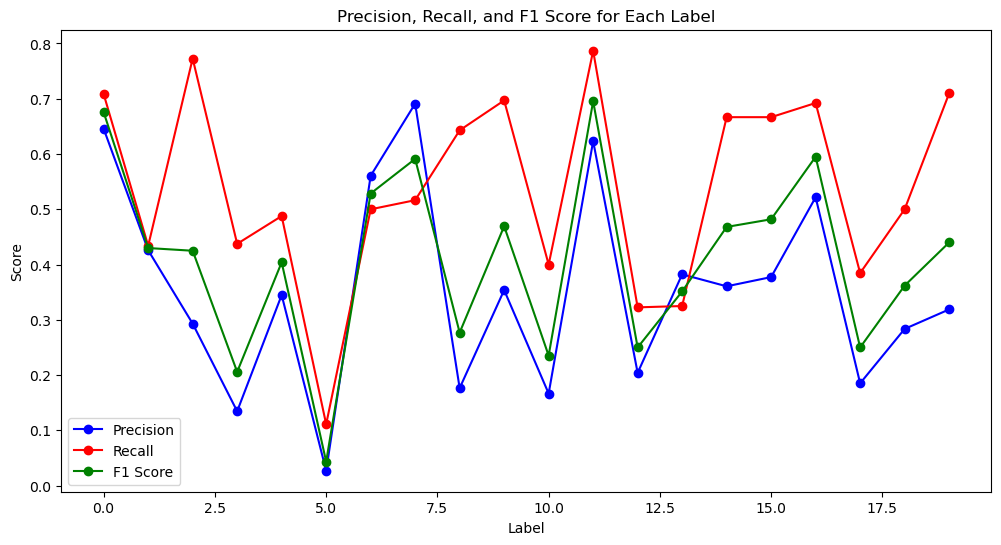

In [153]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score for each label
precision, recall, f1, _ = precision_recall_fscore_support(targets_np, binary_preds_np)

# Plot the metrics
plt.figure(figsize=(12, 6))
x = range(len(precision))
plt.plot(x, precision, marker='o', linestyle='-', color='b', label='Precision')
plt.plot(x, recall, marker='o', linestyle='-', color='r', label='Recall')
plt.plot(x, f1, marker='o', linestyle='-', color='g', label='F1 Score')
plt.xlabel('Label')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score for Each Label')
plt.legend()
plt.show()